In [45]:
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
from poc.functions import State_Timer
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator
import datetime as dt
from datetime import datetime

import pandas as pd
import numpy as np

#from watson_machine_learning_client import WatsonMachineLearningAPIClient
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import sklearn
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.DEBUG)
#logger = logging.getLogger(__name__)


2020-11-08 13:16:56,058 - iotfunctions.enginelog - DEBUG - Console logging has been configured. Level = 10


2020-11-08T13:16:56.058 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


In [46]:
# set Monitor credentials here
credentials = {}
with open('./scripts/credentials_Monitor-Demo2.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db = Database(credentials = credentials)
db_schema = None #  set if you are not using the default


2020-11-08 13:16:59,275 - iotfunctions.db - INFO - Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:9foE9O54ON9fOU61kvlmgjsnmL_Re@db2w-wxdibox.us-south.db2w.cloud.ibm.com:50001/BLUDB;SECURITY=ssl;


2020-11-08T13:16:59.275 INFO iotfunctions.db.__init__ Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:9foE9O54ON9fOU61kvlmgjsnmL_Re@db2w-wxdibox.us-south.db2w.cloud.ibm.com:50001/BLUDB;SECURITY=ssl;


2020-11-08 13:16:59,277 - iotfunctions.db - DEBUG - created a CosClient object


2020-11-08T13:16:59.277 DEBUG iotfunctions.db.__init__ created a CosClient object


2020-11-08 13:17:01,181 - iotfunctions.db - DEBUG - Db connection established


2020-11-08T13:17:01.181 DEBUG iotfunctions.db.__init__ Db connection established


2020-11-08 13:17:03,045 - iotfunctions.db - DEBUG - http request successful. status 200


2020-11-08T13:17:03.045 DEBUG iotfunctions.db.http_request http request successful. status 200


In [47]:
print("Debugging initial df format  ")
# Initialize
states = []
state_column = 'running_status'
state_metric_name = 'RUNNING'
entity_name = 'StateTest'

df = db.read_table(table_name=entity_name, schema=db_schema)
logging.debug("Original Simulation Data to test downtime calculations")
logging.debug("start df ----- %s " % df)
logging.debug("start df ----- %s " % df.columns)

logging.debug("start state_column  ----- %s " %state_column)
logging.debug("start print state_metric_name %s " %state_metric_name)

#df.c1[df.deviceid == 'deviceid'].index.tolist()
logging.debug("Reset index for local testing -----")
df.reset_index(inplace=True)

# List unique values in the df['name'] column
logging.debug('List of Running Status')
states = df[state_column].unique()
logging.debug(states)

logging.debug("Original Simulation Data looking at rows")
for index, row in df.iterrows():
    logger.debug("original rows")
    logger.debug(row)

# Initialize status you need to find running times for
pd.set_option('display.max_columns', None)
for state in states:
    df[state_metric_name] = 0
    df[state] = 0
                    
entity_index_name = df.index.names[0]
#time_index_name = df.index.names[1]
df.reset_index(inplace=True)
asset_list = df[entity_index_name].unique().tolist()
logging.debug("List of unique equipment")
logging.debug(asset_list)

Debugging initial df format  


/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/sqlalchemy/engine/reflection.py:919: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'STATETEST'
  "columns for table '%s'" % (flavor, c, table_name)
2020-11-08 13:17:07,004 - root - DEBUG - Original Simulation Data to test downtime calculations


2020-11-08T13:17:07.004 DEBUG root.<module> Original Simulation Data to test downtime calculations


2020-11-08 13:17:07,015 - root - DEBUG - start df -----    deviceid       evt_timestamp devicetype logicalinterface_id eventtype  \
0    73001A 2020-10-04 07:26:00  StateTest                None      None   
1    73001A 2020-10-04 07:31:00  StateTest                None      None   
2    73001A 2020-10-04 07:46:00  StateTest                None      None   
3    73000A 2020-05-04 21:27:00  StateTest                None      None   
4    73000A 2020-05-04 21:32:00  StateTest                None      None   
5    73000A 2020-05-04 21:37:00  StateTest                None      None   
6    73000A 2020-05-04 21:42:00  StateTest                None      None   
7    73001A 2020-10-04 07:51:00  StateTest                None      None   
8    73001A 2020-10-04 08:00:00  StateTest                None      None   
9    73001A 2020-10-04 07:31:00  StateTest                None      None   
10   73001A 2020-10-04 07:46:00  StateTest                None      None   
11   73001A 2020-10-04 07:51:00 

2020-11-08T13:17:07.015 DEBUG root.<module> start df -----    deviceid       evt_timestamp devicetype logicalinterface_id eventtype  \
0    73001A 2020-10-04 07:26:00  StateTest                None      None   
1    73001A 2020-10-04 07:31:00  StateTest                None      None   
2    73001A 2020-10-04 07:46:00  StateTest                None      None   
3    73000A 2020-05-04 21:27:00  StateTest                None      None   
4    73000A 2020-05-04 21:32:00  StateTest                None      None   
5    73000A 2020-05-04 21:37:00  StateTest                None      None   
6    73000A 2020-05-04 21:42:00  StateTest                None      None   
7    73001A 2020-10-04 07:51:00  StateTest                None      None   
8    73001A 2020-10-04 08:00:00  StateTest                None      None   
9    73001A 2020-10-04 07:31:00  StateTest                None      None   
10   73001A 2020-10-04 07:46:00  StateTest                None      None   
11   73001A 2020-10-04 07:51:

2020-11-08 13:17:07,017 - root - DEBUG - start df ----- Index(['deviceid', 'evt_timestamp', 'devicetype', 'logicalinterface_id',
       'eventtype', 'format', 'updated_utc', 'running_status', 'date'],
      dtype='object') 


2020-11-08T13:17:07.017 DEBUG root.<module> start df ----- Index(['deviceid', 'evt_timestamp', 'devicetype', 'logicalinterface_id',
       'eventtype', 'format', 'updated_utc', 'running_status', 'date'],
      dtype='object') 


2020-11-08 13:17:07,018 - root - DEBUG - start state_column  ----- running_status 


2020-11-08T13:17:07.018 DEBUG root.<module> start state_column  ----- running_status 


2020-11-08 13:17:07,019 - root - DEBUG - start print state_metric_name RUNNING 


2020-11-08T13:17:07.019 DEBUG root.<module> start print state_metric_name RUNNING 


2020-11-08 13:17:07,020 - root - DEBUG - Reset index for local testing -----


2020-11-08T13:17:07.020 DEBUG root.<module> Reset index for local testing -----


2020-11-08 13:17:07,023 - root - DEBUG - List of Running Status


2020-11-08T13:17:07.023 DEBUG root.<module> List of Running Status


2020-11-08 13:17:07,024 - root - DEBUG - ['RUNNING' 'STOPPED']


2020-11-08T13:17:07.024 DEBUG root.<module> ['RUNNING' 'STOPPED']


2020-11-08 13:17:07,025 - root - DEBUG - Original Simulation Data looking at rows


2020-11-08T13:17:07.025 DEBUG root.<module> Original Simulation Data looking at rows


2020-11-08 13:17:07,027 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.027 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,028 - __main__ - DEBUG - index                                    0
deviceid                            73001A
evt_timestamp          2020-10-04 07:26:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:26:00
running_status                     RUNNING
date                      10/04/2020 07:26
Name: 0, dtype: object


2020-11-08T13:17:07.028 DEBUG __main__.<module> index                                    0
deviceid                            73001A
evt_timestamp          2020-10-04 07:26:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:26:00
running_status                     RUNNING
date                      10/04/2020 07:26
Name: 0, dtype: object


2020-11-08 13:17:07,031 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.031 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,032 - __main__ - DEBUG - index                                    1
deviceid                            73001A
evt_timestamp          2020-10-04 07:31:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:31:00
running_status                     STOPPED
date                      10/04/2020 07:31
Name: 1, dtype: object


2020-11-08T13:17:07.032 DEBUG __main__.<module> index                                    1
deviceid                            73001A
evt_timestamp          2020-10-04 07:31:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:31:00
running_status                     STOPPED
date                      10/04/2020 07:31
Name: 1, dtype: object


2020-11-08 13:17:07,035 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.035 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,035 - __main__ - DEBUG - index                                    2
deviceid                            73001A
evt_timestamp          2020-10-04 07:46:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:46:00
running_status                     RUNNING
date                      10/04/2020 07:46
Name: 2, dtype: object


2020-11-08T13:17:07.035 DEBUG __main__.<module> index                                    2
deviceid                            73001A
evt_timestamp          2020-10-04 07:46:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:46:00
running_status                     RUNNING
date                      10/04/2020 07:46
Name: 2, dtype: object


2020-11-08 13:17:07,038 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.038 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,039 - __main__ - DEBUG - index                                    3
deviceid                            73000A
evt_timestamp          2020-05-04 21:27:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:27:00
running_status                     RUNNING
date                      05/04/2020 21:27
Name: 3, dtype: object


2020-11-08T13:17:07.039 DEBUG __main__.<module> index                                    3
deviceid                            73000A
evt_timestamp          2020-05-04 21:27:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:27:00
running_status                     RUNNING
date                      05/04/2020 21:27
Name: 3, dtype: object


2020-11-08 13:17:07,042 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.042 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,043 - __main__ - DEBUG - index                                    4
deviceid                            73000A
evt_timestamp          2020-05-04 21:32:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:32:00
running_status                     STOPPED
date                      05/04/2020 21:32
Name: 4, dtype: object


2020-11-08T13:17:07.043 DEBUG __main__.<module> index                                    4
deviceid                            73000A
evt_timestamp          2020-05-04 21:32:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:32:00
running_status                     STOPPED
date                      05/04/2020 21:32
Name: 4, dtype: object


2020-11-08 13:17:07,045 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.045 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,046 - __main__ - DEBUG - index                                    5
deviceid                            73000A
evt_timestamp          2020-05-04 21:37:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:37:00
running_status                     RUNNING
date                      05/04/2020 21:37
Name: 5, dtype: object


2020-11-08T13:17:07.046 DEBUG __main__.<module> index                                    5
deviceid                            73000A
evt_timestamp          2020-05-04 21:37:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:37:00
running_status                     RUNNING
date                      05/04/2020 21:37
Name: 5, dtype: object


2020-11-08 13:17:07,048 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.048 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,049 - __main__ - DEBUG - index                                    6
deviceid                            73000A
evt_timestamp          2020-05-04 21:42:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:42:00
running_status                     RUNNING
date                      05/04/2020 21:42
Name: 6, dtype: object


2020-11-08T13:17:07.049 DEBUG __main__.<module> index                                    6
deviceid                            73000A
evt_timestamp          2020-05-04 21:42:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:42:00
running_status                     RUNNING
date                      05/04/2020 21:42
Name: 6, dtype: object


2020-11-08 13:17:07,051 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.051 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,052 - __main__ - DEBUG - index                                    7
deviceid                            73001A
evt_timestamp          2020-10-04 07:51:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:51:00
running_status                     STOPPED
date                      10/04/2020 07:51
Name: 7, dtype: object


2020-11-08T13:17:07.052 DEBUG __main__.<module> index                                    7
deviceid                            73001A
evt_timestamp          2020-10-04 07:51:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:51:00
running_status                     STOPPED
date                      10/04/2020 07:51
Name: 7, dtype: object


2020-11-08 13:17:07,054 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.054 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,055 - __main__ - DEBUG - index                                    8
deviceid                            73001A
evt_timestamp          2020-10-04 08:00:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:00:00
running_status                     RUNNING
date                      10/04/2020 08:00
Name: 8, dtype: object


2020-11-08T13:17:07.055 DEBUG __main__.<module> index                                    8
deviceid                            73001A
evt_timestamp          2020-10-04 08:00:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:00:00
running_status                     RUNNING
date                      10/04/2020 08:00
Name: 8, dtype: object


2020-11-08 13:17:07,057 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.057 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,058 - __main__ - DEBUG - index                                    9
deviceid                            73001A
evt_timestamp          2020-10-04 07:31:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:31:00
running_status                     RUNNING
date                      10/04/2020 07:31
Name: 9, dtype: object


2020-11-08T13:17:07.058 DEBUG __main__.<module> index                                    9
deviceid                            73001A
evt_timestamp          2020-10-04 07:31:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:31:00
running_status                     RUNNING
date                      10/04/2020 07:31
Name: 9, dtype: object


2020-11-08 13:17:07,060 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.060 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,061 - __main__ - DEBUG - index                                   10
deviceid                            73001A
evt_timestamp          2020-10-04 07:46:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:46:00
running_status                     RUNNING
date                      10/04/2020 07:46
Name: 10, dtype: object


2020-11-08T13:17:07.061 DEBUG __main__.<module> index                                   10
deviceid                            73001A
evt_timestamp          2020-10-04 07:46:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:46:00
running_status                     RUNNING
date                      10/04/2020 07:46
Name: 10, dtype: object


2020-11-08 13:17:07,064 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.064 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,065 - __main__ - DEBUG - index                                   11
deviceid                            73001A
evt_timestamp          2020-10-04 07:51:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:51:00
running_status                     RUNNING
date                      10/04/2020 07:51
Name: 11, dtype: object


2020-11-08T13:17:07.065 DEBUG __main__.<module> index                                   11
deviceid                            73001A
evt_timestamp          2020-10-04 07:51:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:51:00
running_status                     RUNNING
date                      10/04/2020 07:51
Name: 11, dtype: object


2020-11-08 13:17:07,067 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.067 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,068 - __main__ - DEBUG - index                                   12
deviceid                            73001A
evt_timestamp          2020-10-04 08:01:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:01:00
running_status                     STOPPED
date                      10/04/2020 08:01
Name: 12, dtype: object


2020-11-08T13:17:07.068 DEBUG __main__.<module> index                                   12
deviceid                            73001A
evt_timestamp          2020-10-04 08:01:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:01:00
running_status                     STOPPED
date                      10/04/2020 08:01
Name: 12, dtype: object


2020-11-08 13:17:07,070 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.070 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,071 - __main__ - DEBUG - index                                   13
deviceid                            73000A
evt_timestamp          2020-05-04 21:37:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:37:00
running_status                     STOPPED
date                      05/04/2020 21:37
Name: 13, dtype: object


2020-11-08T13:17:07.071 DEBUG __main__.<module> index                                   13
deviceid                            73000A
evt_timestamp          2020-05-04 21:37:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:37:00
running_status                     STOPPED
date                      05/04/2020 21:37
Name: 13, dtype: object


2020-11-08 13:17:07,074 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.074 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,074 - __main__ - DEBUG - index                                   14
deviceid                            73000A
evt_timestamp          2020-05-04 21:42:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:42:00
running_status                     STOPPED
date                      05/04/2020 21:42
Name: 14, dtype: object


2020-11-08T13:17:07.074 DEBUG __main__.<module> index                                   14
deviceid                            73000A
evt_timestamp          2020-05-04 21:42:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:42:00
running_status                     STOPPED
date                      05/04/2020 21:42
Name: 14, dtype: object


2020-11-08 13:17:07,077 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.077 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,077 - __main__ - DEBUG - index                                   15
deviceid                            73000A
evt_timestamp          2020-05-04 21:47:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:47:00
running_status                     RUNNING
date                      05/04/2020 21:47
Name: 15, dtype: object


2020-11-08T13:17:07.077 DEBUG __main__.<module> index                                   15
deviceid                            73000A
evt_timestamp          2020-05-04 21:47:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:47:00
running_status                     RUNNING
date                      05/04/2020 21:47
Name: 15, dtype: object


2020-11-08 13:17:07,080 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.080 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,080 - __main__ - DEBUG - index                                   16
deviceid                            73000A
evt_timestamp          2020-05-04 21:52:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:52:00
running_status                     STOPPED
date                      05/04/2020 21:52
Name: 16, dtype: object


2020-11-08T13:17:07.080 DEBUG __main__.<module> index                                   16
deviceid                            73000A
evt_timestamp          2020-05-04 21:52:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:52:00
running_status                     STOPPED
date                      05/04/2020 21:52
Name: 16, dtype: object


2020-11-08 13:17:07,083 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.083 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,084 - __main__ - DEBUG - index                                   17
deviceid                            73001A
evt_timestamp          2020-10-04 08:06:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:06:00
running_status                     RUNNING
date                      10/04/2020 08:06
Name: 17, dtype: object


2020-11-08T13:17:07.084 DEBUG __main__.<module> index                                   17
deviceid                            73001A
evt_timestamp          2020-10-04 08:06:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:06:00
running_status                     RUNNING
date                      10/04/2020 08:06
Name: 17, dtype: object


2020-11-08 13:17:07,087 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.087 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,088 - __main__ - DEBUG - index                                   18
deviceid                            73001A
evt_timestamp          2020-10-04 08:11:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:11:00
running_status                     RUNNING
date                      10/04/2020 08:11
Name: 18, dtype: object


2020-11-08T13:17:07.088 DEBUG __main__.<module> index                                   18
deviceid                            73001A
evt_timestamp          2020-10-04 08:11:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:11:00
running_status                     RUNNING
date                      10/04/2020 08:11
Name: 18, dtype: object


2020-11-08 13:17:07,091 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.091 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,092 - __main__ - DEBUG - index                                   19
deviceid                            73001A
evt_timestamp          2020-10-04 07:31:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:31:00
running_status                     RUNNING
date                      10/04/2020 07:31
Name: 19, dtype: object


2020-11-08T13:17:07.092 DEBUG __main__.<module> index                                   19
deviceid                            73001A
evt_timestamp          2020-10-04 07:31:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:31:00
running_status                     RUNNING
date                      10/04/2020 07:31
Name: 19, dtype: object


2020-11-08 13:17:07,095 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.095 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,096 - __main__ - DEBUG - index                                   20
deviceid                            73001A
evt_timestamp          2020-10-04 07:46:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:46:00
running_status                     RUNNING
date                      10/04/2020 07:46
Name: 20, dtype: object


2020-11-08T13:17:07.096 DEBUG __main__.<module> index                                   20
deviceid                            73001A
evt_timestamp          2020-10-04 07:46:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:46:00
running_status                     RUNNING
date                      10/04/2020 07:46
Name: 20, dtype: object


2020-11-08 13:17:07,099 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.099 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,100 - __main__ - DEBUG - index                                   21
deviceid                            73001A
evt_timestamp          2020-10-04 07:51:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:51:00
running_status                     RUNNING
date                      10/04/2020 07:51
Name: 21, dtype: object


2020-11-08T13:17:07.100 DEBUG __main__.<module> index                                   21
deviceid                            73001A
evt_timestamp          2020-10-04 07:51:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 07:51:00
running_status                     RUNNING
date                      10/04/2020 07:51
Name: 21, dtype: object


2020-11-08 13:17:07,103 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.103 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,104 - __main__ - DEBUG - index                                   22
deviceid                            73001A
evt_timestamp          2020-10-04 08:01:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:01:00
running_status                     STOPPED
date                      10/04/2020 08:01
Name: 22, dtype: object


2020-11-08T13:17:07.104 DEBUG __main__.<module> index                                   22
deviceid                            73001A
evt_timestamp          2020-10-04 08:01:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:01:00
running_status                     STOPPED
date                      10/04/2020 08:01
Name: 22, dtype: object


2020-11-08 13:17:07,108 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.108 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,109 - __main__ - DEBUG - index                                   23
deviceid                            73000A
evt_timestamp          2020-05-04 21:37:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:37:00
running_status                     STOPPED
date                      05/04/2020 21:37
Name: 23, dtype: object


2020-11-08T13:17:07.109 DEBUG __main__.<module> index                                   23
deviceid                            73000A
evt_timestamp          2020-05-04 21:37:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:37:00
running_status                     STOPPED
date                      05/04/2020 21:37
Name: 23, dtype: object


2020-11-08 13:17:07,112 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.112 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,113 - __main__ - DEBUG - index                                   24
deviceid                            73000A
evt_timestamp          2020-05-04 21:42:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:42:00
running_status                     STOPPED
date                      05/04/2020 21:42
Name: 24, dtype: object


2020-11-08T13:17:07.113 DEBUG __main__.<module> index                                   24
deviceid                            73000A
evt_timestamp          2020-05-04 21:42:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:42:00
running_status                     STOPPED
date                      05/04/2020 21:42
Name: 24, dtype: object


2020-11-08 13:17:07,115 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.115 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,116 - __main__ - DEBUG - index                                   25
deviceid                            73000A
evt_timestamp          2020-05-04 21:47:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:47:00
running_status                     RUNNING
date                      05/04/2020 21:47
Name: 25, dtype: object


2020-11-08T13:17:07.116 DEBUG __main__.<module> index                                   25
deviceid                            73000A
evt_timestamp          2020-05-04 21:47:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:47:00
running_status                     RUNNING
date                      05/04/2020 21:47
Name: 25, dtype: object


2020-11-08 13:17:07,118 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.118 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,119 - __main__ - DEBUG - index                                   26
deviceid                            73000A
evt_timestamp          2020-05-04 21:52:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:52:00
running_status                     STOPPED
date                      05/04/2020 21:52
Name: 26, dtype: object


2020-11-08T13:17:07.119 DEBUG __main__.<module> index                                   26
deviceid                            73000A
evt_timestamp          2020-05-04 21:52:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-05-04 21:52:00
running_status                     STOPPED
date                      05/04/2020 21:52
Name: 26, dtype: object


2020-11-08 13:17:07,121 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.121 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,121 - __main__ - DEBUG - index                                   27
deviceid                            73001A
evt_timestamp          2020-10-04 08:06:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:06:00
running_status                     RUNNING
date                      10/04/2020 08:06
Name: 27, dtype: object


2020-11-08T13:17:07.121 DEBUG __main__.<module> index                                   27
deviceid                            73001A
evt_timestamp          2020-10-04 08:06:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:06:00
running_status                     RUNNING
date                      10/04/2020 08:06
Name: 27, dtype: object


2020-11-08 13:17:07,124 - __main__ - DEBUG - original rows


2020-11-08T13:17:07.124 DEBUG __main__.<module> original rows


2020-11-08 13:17:07,125 - __main__ - DEBUG - index                                   28
deviceid                            73001A
evt_timestamp          2020-10-04 08:11:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:11:00
running_status                     RUNNING
date                      10/04/2020 08:11
Name: 28, dtype: object


2020-11-08T13:17:07.125 DEBUG __main__.<module> index                                   28
deviceid                            73001A
evt_timestamp          2020-10-04 08:11:00
devicetype                       StateTest
logicalinterface_id                   None
eventtype                             None
format                                None
updated_utc            2020-10-04 08:11:00
running_status                     RUNNING
date                      10/04/2020 08:11
Name: 28, dtype: object


KeyError: None

df.dtypes
deviceid                           object
evt_timestamp              datetime64[ns]
devicetype                         object
logicalinterface_id                object
eventtype                          object
format                             object
updated_utc                datetime64[ns]
drvn_p1                           float64
maintenance_status_x                int64
mainteancne_status_y                int64
predict_drvn_t1                   float64
predict_drvn_p1                   float64
drvn_t2                           float64
drvn_p2                           float64
predict_drvn_t2                   float64
predict_drvn_p2                   float64
run_status                          int64
scheduled_maintenance               int64
unscheduled_maintenance             int64
compressor_in_x                   float64
compressor_in_y                   float64
asset_id                           object
compressor_out_x                  float64
drvr_rpm                

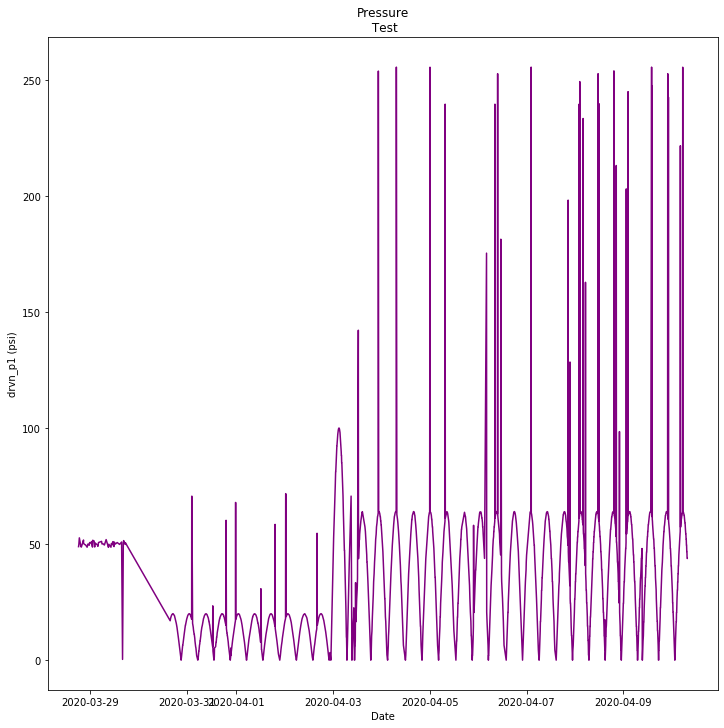

In [125]:
# Make sure you have good data
print ("df.dtypes")
print (df.dtypes)

# Convert evt_timestamp so that you can use it to plot x axix by time.
df['evt_timestamp'] = pd.to_datetime(df['evt_timestamp'])
print ("plot original time series data")

# Create figure and plot raw data 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis use ax.plot(data time for x axis, pressure for y axis) 
# For line use ax.plot and for bar chart use: ax.bar
ax.plot(df[(df.deviceid == '73001') & (df['evt_timestamp'] < pd.Timestamp('2020-04-10 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
        df[(df.deviceid == '73001') & (df['evt_timestamp'] < pd.Timestamp('2020-04-10 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
        color='purple')

# Works Bar chart. Add x-axis and y-axis use ax.plot for line and ax.bar for bar chart
# ax.plot(df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
#        df.loc[df['deviceid'] == '73001'].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
#        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="drvn_p1 (psi)",
       title="Pressure\n Test")

plt.show()

In [129]:

# build custom model locally (user notebook will go here) Score by individual asset 
# columns = input_columns that come as input arguements to custom function in Catalog
# columns = input_columns
print ( df.columns )
print ("dataframe columns")
columns = ['drvn_p1', 'drvr_rpm']
s_df = df.loc[df['deviceid'] == "73001", :][columns]
rows = [list(r) for i,r in s_df.iterrows()]

print ('s_df.shape 1')
print (s_df.shape)
print (s_df)

# create a model (using IsolationForest here with default settings)
clf = IsolationForest()

# place classifier in a sklearn "pipeline"
pipeline = Pipeline( steps = [ ( "classifier", clf ) ] )

# fit data to model pipeline
pipeline.fit(rows)

#s_df = df[columns]
#rows = [list(r) for i,r in s_df.iterrows()]

# test model
results = pipeline.predict(rows)
s_df.loc[: ,'anomaly_score'] = results
print(s_df.head())

from collections import Counter
print(Counter(results))

#Select the anomaly_score column and asset the resulting prediction score to it.

print ('s_df.shape 2')
print (s_df.shape)
print(s_df)

Index(['deviceid', 'evt_timestamp', 'devicetype', 'logicalinterface_id',
       'eventtype', 'format', 'updated_utc', 'drvn_p1', 'maintenance_status_x',
       'mainteancne_status_y', 'predict_drvn_t1', 'predict_drvn_p1', 'drvn_t2',
       'drvn_p2', 'predict_drvn_t2', 'predict_drvn_p2', 'run_status',
       'scheduled_maintenance', 'unscheduled_maintenance', 'compressor_in_x',
       'compressor_in_y', 'asset_id', 'compressor_out_x', 'drvr_rpm',
       'compressor_out_y', 'drvn_flow', 'run_status_x', 'drvn_t1',
       'run_status_y', 'anomaly_score'],
      dtype='object')
dataframe columns
s_df.shape 1
(8539, 2)
         drvn_p1    drvr_rpm
0       0.322422    1.016982
21     48.697716   -1.244989
34     51.755351    0.222056
39     49.895224   -0.261683
68     49.508695   -0.337837
82     51.085613    0.554435
97     51.334664   -0.570295
102    50.537194    1.278511
110     0.000000    0.000000
115     2.608547    1.043419
120     4.538127    3.176689
125     7.039869    7.743856
1

/Users/carlos.ferreira1ibm.com/ve/iot-python3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


      drvn_p1  drvr_rpm  anomaly_score
0    0.322422  1.016982             -1
21  48.697716 -1.244989             -1
34  51.755351  0.222056             -1
39  49.895224 -0.261683             -1
68  49.508695 -0.337837             -1
Counter({1: 7740, -1: 799})
s_df.shape 2
(8539, 3)
         drvn_p1    drvr_rpm  anomaly_score
0       0.322422    1.016982             -1
21     48.697716   -1.244989             -1
34     51.755351    0.222056             -1
39     49.895224   -0.261683             -1
68     49.508695   -0.337837             -1
82     51.085613    0.554435             -1
97     51.334664   -0.570295             -1
102    50.537194    1.278511             -1
110     0.000000    0.000000             -1
115     2.608547    1.043419              1
120     4.538127    3.176689              1
125     7.039869    7.743856              1
130     7.648142    9.177770              1
135     9.993092   15.988948              1
140    12.167318   24.334636              1
145    13.1


 -- Right after adding deviceid column and evt_timestamp  -- 

         drvn_p1    drvr_rpm  anomaly_score deviceid  \
0       0.322422    1.016982             -1    73001   
21     48.697716   -1.244989             -1    73001   
34     51.755351    0.222056             -1    73001   
39     49.895224   -0.261683             -1    73001   
68     49.508695   -0.337837             -1    73001   
82     51.085613    0.554435             -1    73001   
97     51.334664   -0.570295             -1    73001   
102    50.537194    1.278511             -1    73001   
110     0.000000    0.000000             -1    73001   
115     2.608547    1.043419              1    73001   
120     4.538127    3.176689              1    73001   
125     7.039869    7.743856              1    73001   
130     7.648142    9.177770              1    73001   
135     9.993092   15.988948              1    73001   
140    12.167318   24.334636              1    73001   
145    13.178669   28.993073            

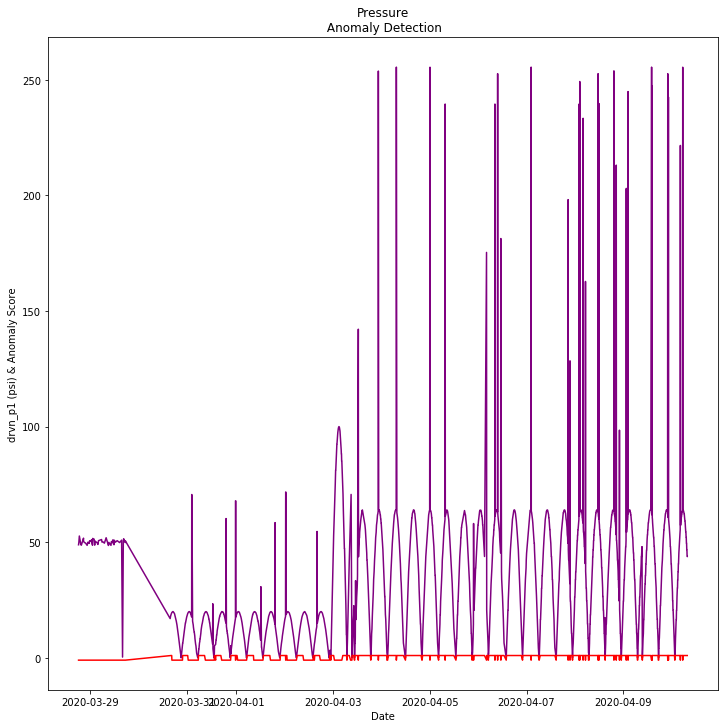

In [130]:
# Merge s_df anomaly _scores to the original df. 
# Add missing deviceid columns to scored s_df
s_df['deviceid'] = '73001'
# Get the original evt_timestamp from the original df and insert it to the scored df so that you avoid column mismatch when merging.
#s_df.insert(1, 'evt_timestamp', df.loc[df['deviceid'] == '73001', ['evt_timestamp']], True)
s_df['evt_timestamp'] = pd.to_datetime(df['evt_timestamp'])

print("\n -- Right after adding deviceid column and evt_timestamp  -- \n")
print(s_df)
    
# combine_first the s_df anomaly _scores column to the original df. 
df_combine_first = s_df.combine_first(df)
print('df_combine_first')
print (df_combine_first)
#print ("df_combine_first.dtypes")
#print (df_combine_first.dtypes)

print('Get df_to_plot')

# Create figure and plot raw data 
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(12, 12))
# Add x-axis and y-axis use ax.plot(data time for x axis, pressure for y axis) 
# For line use ax.plot and for bar chart use: ax.bar
#ax.plot(df_combine_first[(df_combine_first.deviceid == '73001') & (df_combine_first['evt_timestamp'] < pd.Timestamp('2020-03-31 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
#        df_combine_first[(df_combine_first.deviceid == '73001') & (df_combine_first['evt_timestamp'] < pd.Timestamp('2020-03-31 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
#        color='purple')
#ax.plot(df_combine_first[(df_combine_first.deviceid == '73001') & (df_combine_first['evt_timestamp'] < pd.Timestamp('2020-03-31 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
#        df_combine_first[(df_combine_first.deviceid == '73001') & (df_combine_first['evt_timestamp'] < pd.Timestamp('2020-03-31 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['anomaly_score']*10,
#        color='red')
# Set title and labels for axes
#ax.set(xlabel="Date",
#       ylabel="Score Value or Pressure (psi)",
#       title="Pressure\n and Anomaly Score")

 # Validate you are getting good data for a single asset by plotting data
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.backends.backend_pdf import PdfPages
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis use ax.plot for line and ax.bar for bar chart
ax.plot(df_combine_first.loc[(df_combine_first.deviceid == '73001') & (df_combine_first.evt_timestamp < pd.Timestamp('2020-04-10 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
       df_combine_first.loc[(df_combine_first.deviceid == '73001') & (df_combine_first.evt_timestamp < pd.Timestamp('2020-04-10 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['drvn_p1'],
       color='purple')
ax.plot(df_combine_first.loc[(df_combine_first.deviceid == '73001') & (df_combine_first.evt_timestamp < pd.Timestamp('2020-04-10 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['evt_timestamp'],
       df_combine_first.loc[(df_combine_first.deviceid == '73001') & (df_combine_first.evt_timestamp < pd.Timestamp('2020-04-10 07:41:14.687196'))].sort_values(by='evt_timestamp',ascending=True)['anomaly_score'],
       color='red')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="drvn_p1 (psi) & Anomaly Score",
       title="Pressure\n Anomaly Detection")

plt.show()



In [131]:
## publish model

# create WML client
wml_creds_path = '/Users/carlos.ferreira1ibm.com/ws/isolation-forest/wml_credentials.json'
wml_credentials = json.loads(open(wml_creds_path).read())
client = WatsonMachineLearningAPIClient( wml_credentials )

sk_version = sklearn.__version__
metadata = {
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: 'scikit-learn',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: sk_version,
    client.repository.ModelMetaNames.NAME: 'anomaly_model',
    client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION: '3.6'
}

# upload pipeline 
model_details_inmem = client.repository.store_model( pipeline, meta_props=metadata)
model_id_inmem = model_details_inmem["metadata"]["guid"]
deployment_details_inmem = client.deployments.create( artifact_uid=model_id_inmem, name="anomaly_model" )
deployment_id = deployment_details_inmem["metadata"]["guid"]
model_endpoint_url_inmem = client.deployments.get_scoring_url( deployment_details_inmem )
print("model invocation endpoint: " + model_endpoint_url_inmem)
print("Place below line in .env file like so")
print("WATSON_ML_DEPLOYMENT_ID=" + deployment_id) # TODO, need to confirm notebook will reload .env file. Or just change from .env to mem



2020-05-09 21:00:29,301 - ModelCollection - INFO - 
In case of either no query param passed  or 'async':'false' is passed




#######################################################################################

Synchronous deployment creation for uid: '70200bf8-a413-44ba-98cd-32d7bb4f936d' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a42884ac-7c85-46c1-ad62-a0c02ae104a3'
------------------------------------------------------------------------------------------------


model invocation endpoint: https://us-south.ml.cloud.ibm.com/v3/wml_instances/da1a8e1e-84bd-483d-bf4d-14f43b3b7a51/deployments/a42884ac-7c85-46c1-ad62-a0c02ae104a3/online
Place below line in .env file like so
WATSON_ML_DEPLOYMENT_ID=a42884ac-7c85-46c1-ad62-a0c02ae104a3


In [ ]:
from shell.functions import IsolationForestModel
db.register_functions([IsolationForestModel], force_preinstall=True)

In [ ]:
WATSON_ML_ENDPOINT = settings.WATSON_ML_ENDPOINT
WATSON_ML_INSTANCE_ID = settings.WATSON_ML_INSTANCE_ID
WATSON_ML_APIKEY = settings.WATSON_ML_APIKEY
WATSON_ML_DEPLOYMENT_ID = settings.WATSON_ML_DEPLOYMENT_ID

IAM_UID = settings.IAM_UID
IAM_PASSWORD = settings.IAM_PASSWORD

INPUT_COLUMNS = settings.INPUT_COLUMNS or []
if INPUT_COLUMNS and (len(INPUT_COLUMNS) > 0):
    INPUT_COLUMNS = INPUT_COLUMNS.replace(' ', '').split(',')
else:
    INPUT_COLUMNS = []

entity_name = 'Equipment'
INPUT_COLUMNS = ['drvn_p1', 'drvr_rpm']
WATSON_ML_DEPLOYMENT_ID='f19b168b-11b9-4bb2-a31b-cce44eff5311'

entity = EntityType(entity_name, db,
                # following columns can be dynamically generated based on meters associated with each asset
                IsolationForestModel(
                                wml_endpoint=WATSON_ML_ENDPOINT,
                                instance_id=WATSON_ML_INSTANCE_ID,
                                deployment_id=WATSON_ML_DEPLOYMENT_ID,
                                apikey=WATSON_ML_APIKEY,
                                input_columns=INPUT_COLUMNS,
                                output_item = 'anomaly_score'),
                **{
                  '_timestamp' : 'evt_timestamp',
                  '_db_schema' : db_schema}
)
entity.exec_local_pipeline()


In [ ]:
'''











'''



In [ ]:
entity = EntityType('kb_anomaly', db,
                    Column('deviceid',String(50)),
                    Column('anomaly_score', Integer()),
                    Column("torque", Integer()),
                    Column("acc", Integer()),
                    Column("load", Integer()),
                    Column("tool_type", Integer()),
                    Column("speed", Float()),
                    Column("travel_time", Float()),
                    **{
                      '_timestamp' : 'evt_timestamp',
                      # '_production_mode': False,
                      '_db_schema' : db_schema}
)

entity.register(raise_error=False)

In [3]:
# df = pd.read_csv('/Users/carlos.ferreira1ibm.com/ws/isolation-forest/cf_anomaly_dump.csv')
df = db.read_table(table_name='Equipment', schema=db_schema)
df.head()
df['devicetype'] = "Equipment"
# df.head()
df.to_csv('/Users/carlos.ferreira1ibm.com/ws/isolation-forest/cf_anomaly_dump.csv')


2020-04-02 22:58:28,414 - iotfunctions.db - DEBUG - 
<module 'custom.functions' from '/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/custom/functions.py'> is preinstalled False

2020-04-02 22:58:28,415 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'wml_endpoint', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Endpoint to WML service where model is hosted', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-04-02 22:58:28,416 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'instance_id', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Instance ID for WML model', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-04-02 22:58:28,417 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'deployment_id', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Deployment ID for WML model', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-04-02 22:58:28,418 - iotfunctions.base - DEBUG

''

In [139]:
wml_credentials

{'apikey': 'rRjjtJevY3Hk9X7lD3tC8ay6xkBJmTiIT_oKJkCaVLKe',
 'iam_apikey_description': 'Auto-generated for key 42841805-1acb-4363-9b91-01879debc973',
 'iam_apikey_name': 'Service credentials-1',
 'iam_role_crn': 'crn:v1:bluemix:public:iam::::serviceRole:Writer',
 'iam_serviceid_crn': 'crn:v1:bluemix:public:iam-identity::a/f65bf29af08809df5174fedfe7bf9d3b::serviceid:ServiceId-2e8b108b-d201-4a45-a33b-4d306210e574',
 'instance_id': 'da1a8e1e-84bd-483d-bf4d-14f43b3b7a51',
 'url': 'https://us-south.ml.cloud.ibm.com'}

In [ ]:
# generate simulation data
## if we want to use simulation data, run following. this will also create 5 sample entity instances
entity_name = 'kb_anomaly'
print("Generating sample data for " + entity_name)
entity.generate_data(days=2.0, drop_existing=True)


In [ ]:
df = pd.read_csv('/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/equipment_dump.csv')
df['deviceid'].unique()

unscored_rows_idx = df.loc[df['anomaly_score'] == 0, :].index
df.iloc[unscored_rows_idx]
# df.columns

# write data to disk
# entity_name = 'Equipment'
# open(entity_name + '_dump.csv', 'w+').write(df.to_csv())

In [ ]:

## create and register entity
## only required if entity does not exist already
if settings.ENTITY_NAME:
    entity_name = settings.ENTITY_NAME

if settings.INPUT_COLUMNS:
    input_columns = settings.INPUT_COLUMNS.replace(' ', '').split(',')

# if settings.OUTPUT_COLUMNS:
#     output_columns = settings.OUTPUT_COLUMNS.replace(' ', '').split(',')
# else:
#     # defaulting
#     output_columns = [Column('anomaly_score',Integer, default=0)]




entity_columns = [Column('anomaly_score',Integer(), default=0)] + list(map(lambda x: Column(x, Float()), input_columns))  #   Column('anomaly_score', Integer()))

print(entity_columns)

entity_name = "kb_anomaly_test1"
print("creating entity: " + entity_name)

entity = EntityType(entity_name, db,
                    *entity_columns,
                    **{
                      '_timestamp' : 'evt_timestamp',
                      '_db_schema' : db_schema}
                   )
print("Registering entity")
entity.register()
print("Entity registered")

# entity.generate_data(days=2.0, drop_existing=True)




In [ ]:

# reduce entity dataframe to relevant input columns
if settings.INPUT_COLUMNS:
    columns = (settings.INPUT_COLUMNS).split(', ')
else:
    columns = []

    
columns = ['drvn_flow', 'drvn_t1', 'drvn_t2', 'drvn_p1', 'drvn_p2']

if len(columns) > 0:
    print("filtering columns")
    print(columns)
    s_df = df[columns]
else:
    print("using original dataframe")
    s_df = df

print(s_df.head())

# convert dataframe to 2d array (as expected by WML)
rows = [list(r) for i,r in s_df.iterrows()]
